# CHAPTER4. 모델훈련

- 선형 회귀 (Linear Regression)
- 경사 하강법 (GD, Gradient Descent)
- 다항 회귀 (Polynomial Regression)
- 학습 곡선 (Learning Curve)
- 규제가 있는 선형모델
- 로지스틱 회귀 (Logistic Regression)

---

## 4.1 선형 회귀 (Linear Regression)

In [1]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [2]:
import matplotlib.pyplot as plt

plt.plot(X, y, 'ko', markersize = 3)
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
# 최적의 theta 찾기

X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) # 정규방정식을 이용한 최적의 theta구하기
theta_best

array([[4.02488814],
       [3.01660187]])

In [4]:
# theta적용

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict =  X_new_b.dot(theta_best)
y_predict

array([[ 4.02488814],
       [10.05809189]])

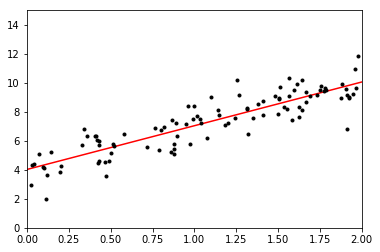

In [5]:
# line추가
plt.plot(X_new, y_predict, 'r-') # (0,3.9), (2, 9.6)을 연결한 직선 그리기
plt.plot(X, y, 'ko', markersize = 3)
plt.axis([0, 2, 0, 15])
plt.show()

In [6]:
# sckit-learn 이용
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[4.02488814] [[3.01660187]]
[[ 4.02488814]
 [10.05809189]]


/anaconda3/envs/practice/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


---

## 4.2 경사 하강법 (GD, Gradient Descent)

In [7]:
# 배치 경사 하강법

eta = 0.1 # Learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위로 선정 shape : (2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) -y)
    theta = theta - eta * gradients
    
theta

array([[4.02488814],
       [3.01660187]])

In [8]:
# 확률적 경사 하강법

n_epochs = 50
t0, t1 = 5, 50 # 학습 스케쥴 하이퍼파라미터
m = 1000

def learning_schedule(t):
    return t0 / (t + t+1)

theta = np.random.randn(2,1) # 무작위로 선정

for epoch in range(n_epochs):
    
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index +1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        
theta

array([[-290.98775936],
       [ 234.63826508]])

In [9]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 50, penalty = None, eta0 = 0.1) # max_iter = epoch
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([4.04024605]), array([3.03430632]))

In [10]:
# 미니배치 경사 하강법

#### 선형 회귀를 사용한 알고리즘 비교

|알고리즘|m이 클때|외부메모리 학습지원|n이 클때|하이퍼파라미터 수|스케일 조정 필요|사이킷런|
|--|--|--|--|--|--|
|정규방정식|빠름|No|느림|0|No|LinearRegression|
|배치 GD|느림|No|빠름|2|Yes|n/a|
|확률적 경사 하강법|빠름|Yes|빠름|>=2|Yes|SGDRegressor|
|미니배치 경사 하강법|빠름|Yes|빠름|>=2|Yes|n/a|


---

## 4.3 다항 회귀 (Polynomial Regression)

In [11]:
# dataset
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.rand(m, 1)

In [12]:
# 다항회귀
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)

print(X[0])
print(X_poly[0])

[2.85591303]
[2.85591303 8.15623921]


In [13]:
# predict
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.5006577]), array([[0.99705644, 0.49562227]]))

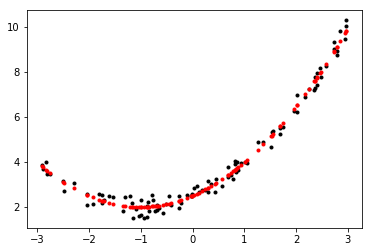

In [14]:
# plot
predict = lin_reg.predict(X_poly)
plt.plot(X, y, 'ko', markersize = 3)
plt.plot(X, predict, 'ro', markersize = 3)
plt.show()

---

## 4.4 학습 곡선 (Learning Curve)

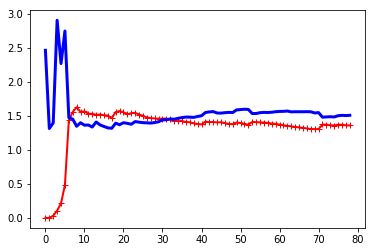

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# 과소적합 모델
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth = 2, label = 'Train set')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth = 3, label = 'Test set')
    
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)       

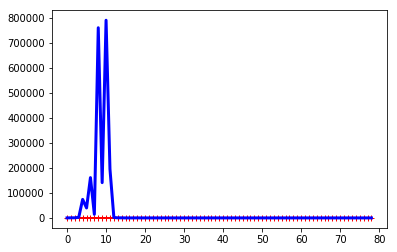

In [16]:
from sklearn.pipeline import Pipeline

# 과대적합 모델
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree = 10, include_bias = False)),
    ('lin_reg', LinearRegression())])

plot_learning_curves(polynomial_regression, X, y)

---

## 4.5 규제가 있는 선형모델

#### 4.5.1 Ridge

In [17]:
# 정규방정식
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1, solver = 'cholesky')
ridge_reg.fit(X, y)
print(ridge_reg.predict([[1.5]]))

# Gredient Descent
sgd_reg = SGDRegressor(max_iter = 5, penalty = 'l2') # l2가 릿지회귀와 같은 원리
sgd_reg.fit(X, y.ravel())
print(sgd_reg.predict([[1.5]]))

[[5.57746644]]
[4.77449313]


#### 4.5.2 Lasso (Least Absolute Shrinkage and Selection Operator)

In [18]:
# 정규방정식
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
print(lasso_reg.predict([[1.5]]))

# Gredient Descent
sgd_reg = SGDRegressor(max_iter = 5, penalty = 'l1') # l2가 릿지회귀와 같은 원리
sgd_reg.fit(X, y.ravel())
print(sgd_reg.predict([[1.5]]))

[5.5340202]
[4.78884626]


#### 4.5.3 Elastic Net

In [19]:
# 정규방정식
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X, y)
print(elastic_net.predict([[1.5]]))

# Gredient Descent
sgd_reg = SGDRegressor(max_iter = 5, penalty = 'elasticnet') # l2가 릿지회귀와 같은 원리
sgd_reg.fit(X, y.ravel())
print(sgd_reg.predict([[1.5]]))

[5.53045441]
[4.7624363]


#### 4.5.4 조기 종료

In [20]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# 데이터 준비
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree = 90, include_bias = False)),
    ('std_scaler', StandardScaler()) ])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(n_iter = 1, warm_start = True, penalty = None,
                       learning_rate = 'constant', eta0 = 0.0005)

minimum_val_error = float('inf')
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
        
print(best_epoch)
print(best_model)

989
SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0005,
       fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=1, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=True)


---

## 4.6 로지스틱 회귀

In [21]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [22]:
# dataset
X = iris['data'][:, 3:]
y = (iris['target'] == 2).astype(np.int)

In [23]:
from sklearn.linear_model import LogisticRegression
# modeling
log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

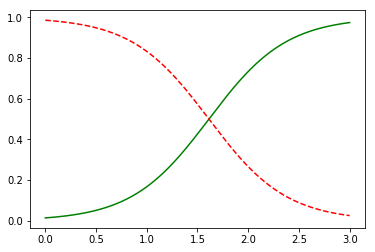

In [24]:
# 추정 확률과 경계
X_new = np.linspace(0, 3, 1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], 'g-', label = 'Iris Virginica O')
plt.plot(X_new, y_proba[:, 0], 'r--', label = 'Iris Virginica X')
plt.show()

In [25]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

In [26]:
# softmax
X = iris['data'][:, (2,3)]
y = iris['target']

# modeling
softmax_reg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C = 10)
softmax_reg.fit(X, y)

print(softmax_reg.predict([[5, 2]]))
print(softmax_reg.predict_proba([[5, 2]])) # 각 클래스별 확률

[2]
[[6.33134077e-07 5.75276067e-02 9.42471760e-01]]
